<center> <b>Geospatial Fellows Program</b> </center>


# Identifying High Accuracy Regions in Traffic Camera Images to Enhance the Estimation of Road Traffic Metrics: A Quadtree-based Method and Applications 
<i>Yue Lin, Ningchuan Xiao</i>

This Jupyter notebook illustrates a quadtree-based algorithm to establish the image regions with high vehicle detection accuracy. A case study is presented to demonstrate how the use of these high accuracy regions can produce reliable road traffic metrics from traffic camera images.

## Notebook Outline
- [Introduction](#intro)
- [Vehicle detector](#det)
- [Quadtree-based algorithm for HAIR identification](#qtree)
    - [Extacting the HAIR](#hair)
    - [Error measurement](#error)
- [Georeferencing and traffic density estimation](#georef)
- [References](#ref)

<a id='intro'></a>
## Introduction
Traffic cameras have become an important data source for transportation management and control. However, deriving reliable traffic metrics from the camera feeds is challenging due to the limitations of current vehicle detection techniques, as well as the various camera conditions such as height and resolution. The figure below shows two examples of using a state-of-the-art deep learning detector to identify the vehicles in traffic images. It is clear that vehicles distant from the camera are often too small to be detected. Missed small vehicles tend to result in significant errors in the estimation of road traffic metrics. 

<img src='./figs/missed.png' width='800'/>

In this Jupyter notebook, we illustrate a quadtree-based algorithm that continuously partitions the image extent until only regions with high detection accuracy are remained. These regions are referred to as the high-accuracy identification regions (HAIR), which will be used to derive reliable road traffic metrics such as traffic density, flow, and speed. A case study in Central Ohio is presented to demonstrate how the use of HAIR can help to improve the accuracy of traffic density estimates using images from a camera. 

<a id='det'></a>
## Vehicle detector

The use of HAIR assumes that some object detector is available to identify the vehicles present in the images. In this project, a deep learning model called EfficientDet[<sup>1</sup>](#fn1) is used for vehicle identification. EfficientDet is a family of 8 object detection models (EfficientDet-d0 through d7) which share the same architecture. EfficientDet-d0 is the baseline model, and each of the next model has a larger size measured by its depth (number of layers), width (size of layers), and input image resolution. To train and evaluate the EfficientDet models, two data sets are prepared using the feeds from 249 cameras in Central Ohio, which consists of 1,392 and 465 images, respectively. Both data sets are processed through an annotation process where bounding boxes of the vehicles are manually identified. Since the deep learning literature generally suggests the use of a large and diverse training data set to improve detection accuracy, we enrich our training data by two external data sources, STREETS[<sup>2</sup>](#fn2) and WebCamT[<sup>3</sup>](#fn3). The figure below presents the training and evaluation of EfficientDet for vehicle detection.

<img src='./figs/vehicle_detection.png' width='500'/>

<a id='qtree'></a>
## Quadtree-based algorithm for HAIR identification
The purpose of our quadtree-based HAIR identification algorithm is to determine the regions in a camera’s field of view that are part of the high accuracy regions. A number of images are needed as the input of this algorithm, where each image contains (1) the manually labeled vehicle bounding boxes that are confirmed to be the ground truth of the vehicles to be detected, and (2) the bounding box of each detected vehicle yielded by some model. Here, we prepare a sample image data set collected from a traffic camera located in Central Ohio. This data set uses similar format to PASCAL VOC 2007[<sup>4</sup>](#fn4), with its directory structured as:  

     |-- sample_cam
        |-- Annotations
        |-- ImageSets
            |-- Main
        |-- JPEGImages
        |-- Predictions

The labeled vehicle bounding boxes are stored under the *Annotations* directory in .xml format, each linked to a traffic image in the *JPEGImages* directory and a filename in the *ImageSets -> Main* directory. The *Predictions* directory contains the predicted vehicle bounding boxes generated by the trained EfficientDet model.

In [1]:
from zipfile import ZipFile
with ZipFile('data/sample_cam.zip', 'r') as zipObj:
  zipObj.extractall('data')

Visualize an image after detection.

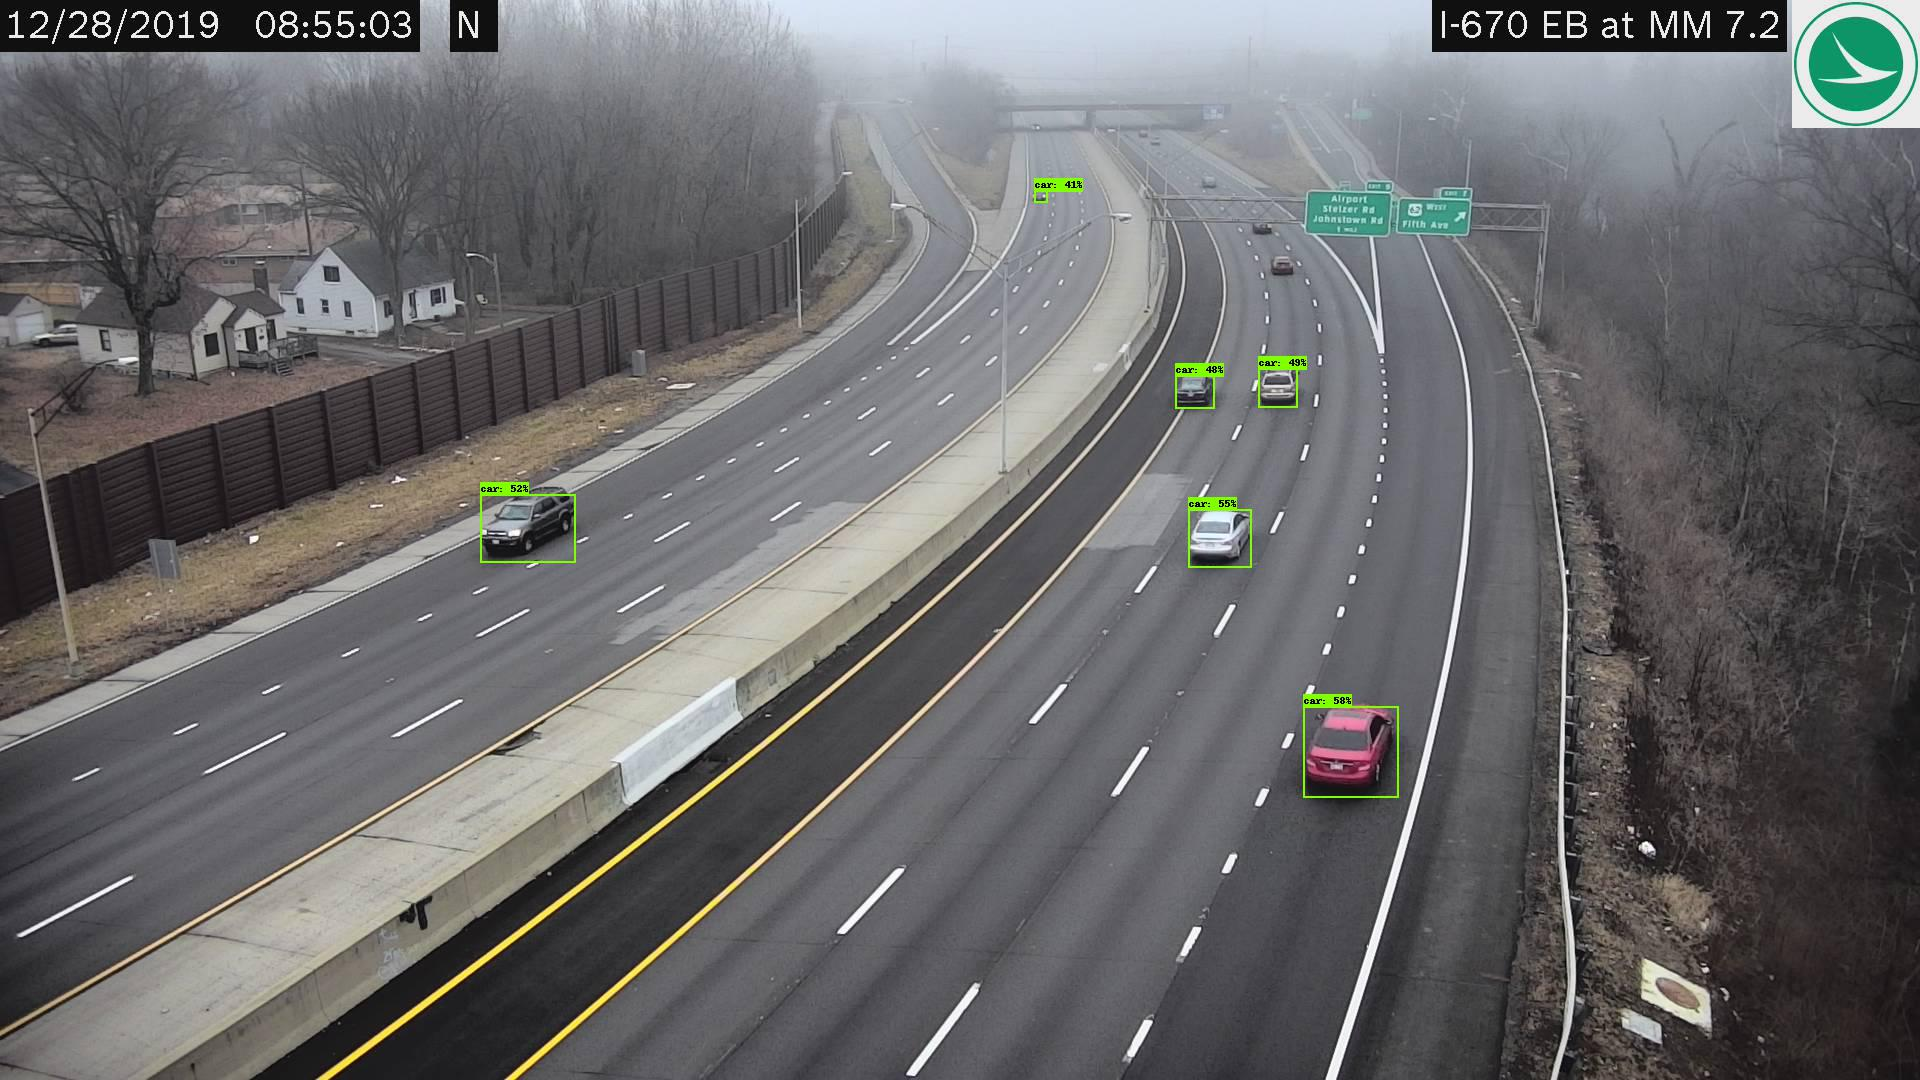

In [2]:
from IPython.display import Image 
pil_img = Image(filename = 'data/sample_cam/Predictions/2019-12-28_08_55_01_camera_145.jpg', width = 600)
display(pil_img)

<a id='hair'></a>
### Extracting the HAIR

The `sampling` function allows users to specify different numbers of images ($N$) when implementing the algorithm.

In [3]:
def sampling(imagesetfile, samplesize):
  with open(imagesetfile, 'r') as f:
    lines = f.readlines()
  imagenames = [x.strip() for x in lines]
  shuffle(imagenames)
  imagenames = sample(imagenames, samplesize)
  return imagenames

Then, we define the `QuadTreeNode` class. A quadtree node refers to a quadrant/sub-quadrant in the image extent. `QuadTreeNode`
strores the extent of the quadrant/sub-quadrant, its four children (possibly all `NULL` if not partitioned), its accuracy measures (regional average precision, precision, recall, F1-score, and accuracy), and whether or not it is selected as part of the HAIR.

In [4]:
class QuadTreeNode(object):
  def __init__(self, extent, nw=None, ne=None, se=None, sw=None, 
                rap=0, prec=0, rec=0, f1=0, acc=0, selected=False):
    self.extent = extent
    self.nw = nw
    self.ne = ne
    self.se = se
    self.sw = sw
    
    self.rap = rap
    self.prec = prec
    self.rec = rec
    self.f1 = f1
    self.acc = acc
    self.selected = selected

The regional average precision of a quadtree node is similar to the average precision metric[<sup>4</sup>](#fn4). It is computed based on the bounding boxes of all the labeled and detected vehicles in the region. If the regional average precision of a node does not reach a user-specified threshold ($a_0$), the `build_qtree` function will partition the corresponding quadrant into four equal sub-quadrants. This process continues until either the accuracy threshold ($a_0$) or the maximal depth ($d_0$) is reached.

In [5]:
def build_qtree(t, imagenames, thresh, maxdepth):
    if not t: 
      return
    
    roibbox = t.extent
    xmin = roibbox[0]
    ymin = roibbox[1]
    xmax = roibbox[2]
    ymax = roibbox[3]
    xmid = (xmin + xmax) / 2.
    ymid = (ymin + ymax) / 2.
    if xmax - xmin < W / 2 ** maxdepth:
      return
    region = np.zeros((2 ** maxdepth, 2 ** maxdepth))
    i = int((ymin - imageextent[1]) * 2 ** maxdepth / H)
    j = int((xmin - imageextent[0]) * 2 ** maxdepth / W)
    region[i, j] = 1

    rec, prec, rap, acc = eval_rap.voc_eval_region(DETPATH, ANNOPATH, imagenames, CLASSNAME, CACHEDIR,
                                                   region, ovthresh = 0.5, use_07_metric = True)
    if rec != 0 and prec != 0:   
      f1 = 2 * rec * prec / (rec + prec)
      t.rec = rec
      t.prec = prec
      t.f1 = f1

    t.rap = rap
    t.acc = acc

    if t.rap >= thresh:
      t.selected = True
    else:
      t.nw = QuadTreeNode([xmin, ymin, xmid, ymid])
      t.ne = QuadTreeNode([xmid, ymin, xmax, ymid])
      t.se = QuadTreeNode([xmid, ymid, xmax, ymax])
      t.sw = QuadTreeNode([xmin, ymid, xmid, ymax])

      build_qtree(t.nw, imagenames, thresh, maxdepth)
      build_qtree(t.ne, imagenames, thresh, maxdepth)
      build_qtree(t.se, imagenames, thresh, maxdepth)
      build_qtree(t.sw, imagenames, thresh, maxdepth)

The `search_qtree` function outputs the derived HAIR.

In [6]:
def search_qtree(t, p):
    if t is None:
      return
    
    px = p[0]
    py = p[1]

    xmin = t.extent[0]
    ymin = t.extent[1]
    xmax = t.extent[2]
    ymax = t.extent[3]
    xmid = (xmin + xmax) / 2.
    ymid = (ymin + ymax) / 2.

    if xmin <= px < xmax and ymin <= py < ymax:
      if t.selected == True:
        return True
      elif t.nw or t.ne or t.se or t.sw:
        if xmin <= px < xmid and ymin <= py < ymid:
          return search_qtree(t.nw, p)
        elif xmid <= px < xmax and ymin <= py < ymid:
          return search_qtree(t.ne, p)
        elif xmid <= px < xmax and ymid <= py < ymax:
          return search_qtree(t.se, p)
        elif xmin <= px < xmid and ymid <= py < ymax:
          return search_qtree(t.sw, p)

Now we have defined all the necessary class and functions. One step before running the algorithm, we need to setup some libraries and input parameters.

In [7]:
from random import sample, shuffle, seed
import numpy as np
from model import eval_rap
import warnings
warnings.filterwarnings('ignore')

DETPATH = "data/sample_cam/Predictions"
ANNOPATH = "data/sample_cam/Annotations"
IMAGESETFILE = "data/sample_cam/ImageSets/Main/trainval.txt"
CLASSNAME = "car"
CACHEDIR = "data/sample_cam/cache"
H = 1080
W = 1920
imageextent = [0, 0, W, H]
samplesize = 50           # number of images
thresh = 0.75             # accuracy threshold
maxdepth = 3              # maximal depth

Extract the HAIR and print it out in a matrix form (HAIR labeled as 1) . Try different seeds and parameter values if you want.

In [8]:
seed(1)

# initialize quads
quads = np.zeros((2 ** maxdepth, 2 ** maxdepth))

# obtain the HAIR
imagenames = sampling(IMAGESETFILE, samplesize)
t = QuadTreeNode(imageextent)
build_qtree(t, imagenames, thresh, maxdepth)

# print out the HAIR
for i in range(2 ** maxdepth):
  ymin = imageextent[1] + i * H / 2 ** maxdepth
  for j in range(2 ** maxdepth):
    xmin = imageextent[0] + j * W / 2 ** maxdepth
    p = [xmin, ymin]
    if search_qtree(t, p):
      quads[i, j] = 1

print(quads)

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 1.]
 [0. 0. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]


We can also use bootstrapping to derive the HAIR under multiple equal-size random samples, and then calculate the probability of each quadrant to be part of the HAIR. 

In [9]:
seed(1)
n = 10   # number of bootstrap samples

# initialize quads
quads_prob = np.zeros((2 ** maxdepth, 2 ** maxdepth))

# bootstrap
for k in range(n):
  # obtain the HAIR
  imagenames = sampling(IMAGESETFILE, samplesize)
  t = QuadTreeNode(imageextent)
  build_qtree(t, imagenames, thresh, maxdepth)
    
  # calculate probability to be part of the HAIR
  for i in range(2 ** maxdepth):
    ymin = imageextent[1] + i * H / 2 ** maxdepth
    for j in range(2 ** maxdepth):
      xmin = imageextent[0] + j * W / 2 ** maxdepth
      p = [xmin, ymin]
      if search_qtree(t, p):
        quads_prob[i,j] += 1. / n

print(quads_prob)

[[0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.9 0.  0.  1.  1. ]
 [0.  0.  1.  1.  1.  1.  1.  1. ]
 [0.9 0.9 1.  1.  1.  1.  1.  1. ]
 [1.  0.9 1.  1.  1.  1.  1.  1. ]
 [0.9 0.9 1.  1.  1.  1.  1.  1. ]
 [0.9 0.9 1.  1.  1.  1.  1.  1. ]]


In this example, we select the quadrants with a probability higher than 0.8 to form the HAIR collectively. The result is visualized below.

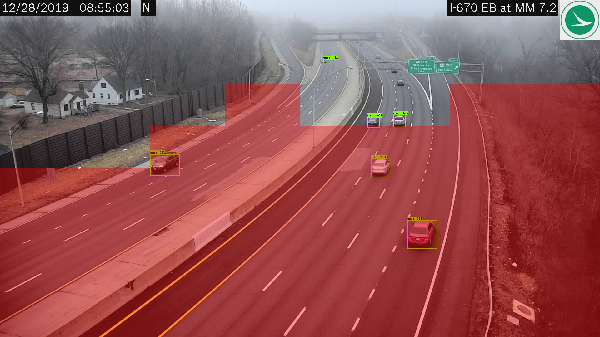

In [10]:
from PIL import Image
from IPython.display import display
prob_thresh = 0.8

# create foreground HAIR image
hair_mtx = quads_prob
foreground = Image.new("RGBA", (W, H), color=(255, 255, 255, 0))
dw = int(W / hair_mtx.shape[0])
dh = int(H / hair_mtx.shape[0])
for i in range(hair_mtx.shape[0]):
  for j in range(hair_mtx.shape[0]):
    if hair_mtx[i, j] > prob_thresh:
      for x in range(j * dw, (j + 1) * dw):
        for y in range(i * dh, (i + 1) * dh):
          foreground.putpixel((x, y), (255, 0, 0, 100))

# overlay the HAIR with a traffic image
background = Image.open('data/sample_cam/Predictions/2019-12-28_08_55_01_camera_145.jpg')
background.paste(foreground, (0, 0), foreground)

display(background.resize((600, int(600 / background.size[0] * background.size[1])), 0))

<a id='error'></a>
### Error measurement

The use of HAIR may bring two types of error that must be addressed. The first type of error occurs when the images used to identify the HAIR are not representative in covering sufficient on-road vehicle positions, and therefore the HAIR cannot achieve high vehicle detection accuracy when applied to new images. Using insufficient number of images ($N$) to derive the HAIR, for example, may cause such an error. The second type of error occurs when some high accuracy regions are not included in the HAIR, which is often related to the maximal depth ($d_0$) in HAIR extraction. A resampling procedure is adopted to minimize the average error brought about by the HAIR.

First, we define a `split` function to split a data set into development and validation sets.  

In [11]:
def split(imagesetfile, samplesize):
  with open(imagesetfile, 'r') as f:
    lines = f.readlines()
  imagenames = [x.strip() for x in lines]
  shuffle(imagenames)
  trainimages = sample(imagenames, samplesize)
  testimages = [x for x in imagenames if x not in trainimages]
  testimages = sample(testimages, 10)
  return trainimages, testimages

Some setups before our error measurement.

In [12]:
from random import sample, shuffle, seed
import numpy as np
import math
from model import eval_rap
from model import eval_cap
import warnings
warnings.filterwarnings('ignore')

DETPATH = "data/sample_cam/Predictions"
ANNOPATH = "data/sample_cam/Annotations"
IMAGESETFILE = "data/sample_cam/ImageSets/Main/trainval.txt"
CLASSNAME = "car"
CACHEDIR = "data/sample_cam/cache"
H = 1080
W = 1920
imageextent = [0, 0, W, H]
samplesize_test = [30, 50, 70]           # number of images in the development set
maxdepth_test = [1, 3]                   # maximal depth
thresh = 0.75                            # accuracy threshold
R = 10                                   # number of resampling iterations

We define a metric called comparative average precision to measure the ability of the derived HAIR to cover all correctly detected vehicles within the entire image extent. The error introduced by the HAIR is then measured as the difference between the CAP of the HAIR and the RAP of the original image extent. Given a pair of $N$ and $d_0$, we repeatedly splitting the data set into development and validation sets and calculating the error. The overall error across all the iterations is estimated using the root mean square error (RMSE), which will be used to determine the parameter values and to identify a robust final HAIR.

For the purpose of demonstration, we set the number of resampling iterations to a relatively small number (10) here.

In [13]:
cap = []
error = []
for samplesize in samplesize_test:
  for maxdepth in maxdepth_test:
    img_mtx = np.ones((2 ** maxdepth, 2 ** maxdepth))
    for k in range(R):
      # obtain the HAIR
      hair_mtx = np.zeros((2 ** maxdepth, 2 ** maxdepth))
      trainimages, testimages = split(IMAGESETFILE, samplesize)
      t = QuadTreeNode(imageextent)
      build_qtree(t, trainimages, thresh, maxdepth)

      for i in range(2 ** maxdepth):
        ymin = imageextent[1] + i * H * 1 / 2 ** maxdepth
        for j in range(2 ** maxdepth):
          xmin = imageextent[0] + j * W * 1 / 2 ** maxdepth
          p = [xmin, ymin]
          if search_qtree(t, p):
            hair_mtx[i,j] = 1

      # calculate cap of the HAIR
      rec_h, prec_h, cap_h, acc_h = eval_cap.voc_eval_hair(DETPATH, ANNOPATH, testimages, CLASSNAME, CACHEDIR,
                                                           hair_mtx, H, W, ovthresh = 0.5)
      cap.append(cap_h)
      # calculate rap of the entire image extent
      rec_i, prec_i, rap_i, acc_i = eval_rap.voc_eval_region(DETPATH, ANNOPATH, testimages, CLASSNAME, CACHEDIR,
                                                             img_mtx, ovthresh = 0.5, use_07_metric = True)
      error.append(cap_h - rap_i)   
    
    # error measurement 
    cap_ave = sum(cap) / len(cap)
    cap_var = sum((i - cap_ave) ** 2 for i in cap) / len(cap)
    cap_rmse = math.sqrt(sum(i ** 2 for i in error) / len(error))
    print('N:', samplesize, 'd0:', maxdepth)
    print('CAP Mean:', cap_ave, 'CAP variance:', cap_var, 'RMSE:', cap_rmse)

N: 30 d0: 1
CAP Mean: 0.35086157650598576 CAP variance: 0.04058899280017085 RMSE: 0.31817333328318287
N: 30 d0: 3
CAP Mean: 0.3913700892830506 CAP variance: 0.02439061445120399 RMSE: 0.26987110142880727
N: 50 d0: 1
CAP Mean: 0.38421624620330663 CAP variance: 0.03043885320221773 RMSE: 0.28929208251973687
N: 50 d0: 3
CAP Mean: 0.3989855230805479 CAP variance: 0.02483761134322773 RMSE: 0.26747880894702886
N: 70 d0: 1
CAP Mean: 0.3896133700957399 CAP variance: 0.027845137769421702 RMSE: 0.27819548367849156
N: 70 d0: 3
CAP Mean: 0.39443875286569136 CAP variance: 0.02362683468700703 RMSE: 0.26709841386391425


The above procedure is able to produce a robust HAIR. We compare the vehicle detection accuracy in the HAIR with that in the entire image extent. For simplicity, we use the first HAIR (`quads`)  we derived in this comparison. It is clear that the vehicle detection accuracy within the HAIR is significantly higher than that in the original image extent.

In [14]:
# RAP of the entire image extent
img_mtx = np.ones((2 ** maxdepth, 2 ** maxdepth))
rec_i, prec_i, rap_i, acc_i = eval_rap.voc_eval_region(DETPATH, ANNOPATH, testimages, CLASSNAME, CACHEDIR,
                                                       img_mtx, ovthresh = 0.5, use_07_metric = True)
print("Image extent - RAP:", rap_i, "rec:", rec_i, "prec:", prec_i)

# RAP of the HAIR
hair_mtx = quads
rec_h, prec_h, rap_h, acc_h = eval_rap.voc_eval_region(DETPATH, ANNOPATH, testimages, CLASSNAME, CACHEDIR,
                                                       hair_mtx, ovthresh = 0.5, use_07_metric = True)
print("HAIR - RAP:", rap_h, "rec:", rec_h, "prec:", prec_h)

Image extent - RAP: 0.6143796589128065 rec: 0.6375838926174496 prec: 0.9405940594059405
HAIR - RAP: 0.9045454545454545 rec: 0.9516129032258065 prec: 0.9833333333333333


<a id='georef'></a>
## Georeferencing and traffic density estimation

To estimate the road traffic metrics (e.g., traffic density) using the HAIR, the images involved are assumed to be georeferenced. To georeference the test images, an orthorectified images covering the study area is retrieved from the [Ohio Statewide Imagery Program](http://gis5.oit.ohio.gov/geodatadownload/). We identify 10 ground control points within the camera's field of view (see the figure below). The *Georeferencer* plugin in [QGIS](https://www.qgis.org/en/site/) is utilized to georeference the camera images to the coordinate system in the orthorectified aerial photos. Based on our georeferencing results, we know that the road length within the entire image extent is 0.663 km, and that within the HAIR is 0.245 km. Traffic density is estimated based on the traffic counts and road lengths within the HAIR. 

<img src='./figs/georef.png' width='400'/>

The errors between the predicted and observed traffic density values within the HAIR and within the original image extent are calculated and compared. The results show that the use of HAIR significantly improves the accuracy of traffic density estimation with a decrease of 74 percent in root mean squared error.

In [18]:
import math
import numpy as np
from model import cnt

hair_anno = []
hair_det = []
all_anno = []
all_det = []
all_len = 663
hair_len = 245
for imagename in testimages:
  # traffic density within the HAIR
  hair_anno_cnt, hair_det_cnt = cnt.count(imagename, ANNOPATH, DETPATH, hair_mtx)
  # traffic density within the original extent
  road_mtx = np.ones((hair_mtx.shape))
  all_anno_cnt, all_det_cnt = cnt.count(imagename, ANNOPATH, DETPATH, road_mtx)
  
  hair_anno.append(hair_anno_cnt/hair_len)
  hair_det.append(hair_det_cnt/hair_len)
  all_anno.append(all_anno_cnt/all_len)
  all_det.append(all_det_cnt/all_len)


# error
var_all = np.var(all_det)
var_hair = np.var(hair_det)
rmse_all = np.sqrt(np.mean(np.subtract(all_anno, all_det)**2))
rmse_hair = np.sqrt(np.mean(np.subtract(hair_anno, hair_det)**2))
bias_all = math.sqrt(rmse_all**2 - var_all)
bias_hair = math.sqrt(rmse_hair**2 - var_hair)
print("Image extent - RMSE:", rmse_all, "bias:", bias_all, "variance:", var_all)
print("HAIR - RMSE:", rmse_hair, "bias:", bias_hair, "variance:", var_hair)

Image extent - RMSE: 0.21272102329506054 bias: 0.17203928283505057 variance: 0.01565271891329916
HAIR - RMSE: 0.11037024510142414 bias: 0.09011446282273029 variance: 0.0040609745939192


<a id='ref'></a>
## References
<span id="fn1"> Tan, M., Pang, R., Le, Q. V., 2020a. EfficientDet: Scalable and Efficient Object Detection, in: Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR). pp. 10781–10790. </span>

<span id="fn2"> Snyder, C., Do, M.N., 2019. STREETS: A Novel Camera Network Dataset for Traffic Flow, in: Wallach, H., Larochelle, H., Beygelzimer, A., D’Alché-Buc, F., Fox, E., Garnett, R. (Eds.), Advances in Neural Information Processing Systems 32 (NIPS 2019). Curran Associates, Inc., New York, US, pp. 10242–10253. </span>

<span id="fn3"> Zhang, S., Wu, G., Costeira, J.P., Moura, J.M.F., 2017. Understanding Traffic Density from Large-Scale Web Camera Data, in: Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition (CVPR). Honolulu, HI, USA, pp. 4264–4273. </span>

<span id="fn4"> Everingham, M., Gool, L.J. Van, Williams, C., Winn, J.M., Zisserman, A., 2010. The Pascal Visual Object Classes (VOC) Challenge. Int. J. Comput. Vis. 88, 303–338. </span> 